# Inputs Modelo PACO

In [27]:
import pandas as pd 
import numpy as np 
import os
from google.cloud import bigquery
from google.oauth2 import service_account
from datetime import datetime
from dateutil.relativedelta import relativedelta
import itertools

pd.set_option('display.max_columns', None)

# declaramos las credenciales al entorno de desarollo
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "..\\..\\bd\\0_docs\\datahub-deacero-adojeda.json"

# Crear date_today como el primer día del mes actual
now = datetime.now() - relativedelta(days= 4)

date_today = datetime(now.year, now.month, 1)

# Crear date_last_6m como seis meses antes de date_today
date_last_6m = date_today - relativedelta(months=6)

# Crear date_forecas como seis meses después de date_today
date_forecas = date_today + relativedelta(months=6)

# Mostrar las fechas
print("date_today:", date_today.strftime("%Y-%m-%d"))

print("date_last_6m:", date_last_6m.strftime("%Y-%m-%d"))

print("date_forecas:", date_forecas.strftime("%Y-%m-%d"))


# declaramos las credenciales al entorno de desarollo
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "..\\..\\bd\\0_docs\\datahub-deacero-adojeda.json"

query_str = """
SELECT
FORMAT_DATE('%Y-%m-%d', PARSE_DATE('%B.%Y', mes_anio)) AS MesAnio,
nom_grupo AS NombreGrupo,
nom_direccion AS NombreDireccion,
nom_subdireccion AS NombreSubdireccion,
nom_grupo_estadistico1 AS NombreGrupoEstadistico1,
nom_grupo_estadistico2 AS NombreGrupoEstadistico2,
nom_grupo_estadistico3 AS NombreGrupoEstadistico3,
sum(toneladas_facturadas) AS `Toneladas Facturadas`,
FROM `datahub-deacero.mart_comercial.comercial` 
WHERE 
EXTRACT(YEAR FROM fecha) >= 2022
AND
EXTRACT(YEAR FROM fecha) < 2026
AND
nom_direccion NOT IN  ('FILIALES') --> lo quité de la consulta duplica SUBDIRG3
AND
nom_subdireccion NOT IN  ('SERVICIOS LOGISTICOS DAL USA') --> lo quité de la consulta duplica SUBDIRG3
-- Descartamos los siguientes campos
#AND
#nom_grupo NOT IN ('EMPRESAS RELACIONADAS','TRASPASOS E INTEREMPRESAS')
#AND
#nom_direccion NOT IN ('EXPORTACIÓN ALAMBRES')
#AND
#nom_subdireccion NOT IN ('EXCEDENTES ACEROS','EXCEDENTES ALAMBRES','RESTO ALAMBRES','RESTO INGETEK')
#AND
#nom_grupo_estadistico1 NOT IN ('CHATARRA','DEACERO POWER','INTERNAS PRODUCCION ','LOGÍSTICA','PALANQUILLA','SEGUNDAS')
#AND
#nom_grupo_estadistico2 NOT IN ('SEGUNDAS / EXCEDENTES','CHQ')
#AND
#nom_grupo_estadistico3 NOT IN ('DESPERDICIO','ALAMBRON SEGUNDAS','ALAMBRON EXCEDENTES','ALAMBRON TERCEROS','ALAMBRON OTROS','DERECHO DE VIA','PILOTES','PISO','POLIZAS')
-- Necesitamos que la informacion no sea nula
AND nom_grupo IS NOT NULL
AND nom_direccion IS NOT NULL
AND nom_subdireccion IS NOT NULL
AND nom_grupo_estadistico1 IS NOT NULL
AND nom_grupo_estadistico2 IS NOT NULL
AND nom_grupo_estadistico3 IS NOT NULL
AND  mes_anio IS NOT NULL
GROUP BY 1,2,3,4,5,6,7
ORDER BY 1,2,3,4,5,6,7
"""

client = bigquery.Client(project="demanda-prj-dev")

consulta = query_str

query = client.query(consulta)

pv = query.to_dataframe(create_bqstorage_client=True)

pv.sort_index(inplace=True, ascending=True)

#pv["PVO"] = pv["PVO"].astype(float)

#pv["PV"] = pv["PV"].astype(float)

pv["Toneladas Facturadas"] = pv["Toneladas Facturadas"].astype(float).fillna(0)

pv.MesAnio = pd.to_datetime(pv.MesAnio ).dt.date

pv = pv[pv.MesAnio < date_today.date() ]

pv.to_excel(r".\outputs\HISTORICO_FACTURACION.xlsx", index=False)

date_today: 2025-09-01
date_last_6m: 2025-03-01
date_forecas: 2026-03-01


c:\Users\adojeda\OneDrive - deacero.com\dev\0_envs\.bigquery\Lib\site-packages\google\cloud\bigquery\table.py:1900: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


# POP 
Proceso de Optimización de Pronósticos?

El siguiente notebook permite Optimizar los pronósticos de Subdir-GE3 para seleccionar el modelo más adecuado.

El modelo adecuado será aquel que minimicé el MAPE Deacero a nivel SKU BU - ej. **$min(MAPE_{Deacero})$**  Seleccionado entre los siguientes Modelos

* PVO
* BayesianRidge	
* GradientBoostingRegressor	
* KNeighborsRegressor	
* LGBMRegressor	
* RandomForestRegressor
* Ridge	
* SVR
* XGBRegressor
* Demmand Management 

In [1]:
import pandas as pd 
import numpy as np 
import os
from google.cloud import bigquery
from google.oauth2 import service_account
from datetime import datetime
from dateutil.relativedelta import relativedelta
import itertools

pd.set_option('display.max_columns', None)

# declaramos las credenciales al entorno de desarollo
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "..\\..\\bd\\0_docs\\datahub-deacero-adojeda.json"

# Crear date_today como el primer día del mes actual
now = datetime.now() - relativedelta(days= 4)

date_today = datetime(now.year, now.month, 1)

# Crear date_last_6m como seis meses antes de date_today
date_last_6m = date_today - relativedelta(months=6)

# Crear date_forecas como seis meses después de date_today
date_forecas = date_today + relativedelta(months=6)

# Mostrar las fechas
print("date_today:", date_today.strftime("%Y-%m-%d"))

print("date_last_6m:", date_last_6m.strftime("%Y-%m-%d"))

print("date_forecas:", date_forecas.strftime("%Y-%m-%d"))

date_today: 2025-09-01
date_last_6m: 2025-03-01
date_forecas: 2026-03-01


### Consulta BQ Modelo MAX

In [5]:
query_str = """
SELECT 
  `FECHA_EJECUCION`,
  `FECHA`,
  `COV%`,
  `MAPE%`,
  `MODEL`,
  `NOMBREGRUPOESTADISTICO3`,
  `NOMBRESUBDIRECCION`,
  `Y_HIST`,
  `Y_PREDICCION`,
  `Y_PRONOSTICOS`,
  `Y_TEST`
FROM demanda-prj-dev.pronosticos.forecast_table
WHERE FECHA_EJECUCION = (
  SELECT MAX(FECHA_EJECUCION)
  FROM demanda-prj-dev.pronosticos.forecast_table
  )
"""

client = bigquery.Client(project="demanda-prj-dev")

consulta = query_str

query = client.query(consulta)

forecast = query.to_dataframe()

forecast.sort_index(inplace=True, ascending=True)

forecast["Y_HIST"] = forecast["Y_HIST"].astype(float)

forecast["Y_PREDICCION"] = forecast["Y_PREDICCION"].astype(float)

forecast["Y_PRONOSTICOS"] = forecast["Y_PRONOSTICOS"].astype(float)

forecast["Y_TEST"] = forecast["Y_TEST"].astype(float)

print(forecast.FECHA.value_counts().sort_index().tail(5))

c:\Users\adojeda\OneDrive - deacero.com\dev\0_envs\.bigquery\Lib\site-packages\google\cloud\bigquery\table.py:1900: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


FECHA
2025-10-01    4184
2025-11-01    4184
2025-12-01    4184
2026-01-01    4124
2026-02-01    3954
Name: count, dtype: int64


In [ ]:
forecast.groupby(["FECHA","MODEL"]).agg({ "Y_PRONOSTICOS":"sum"}).unstack(-1).tail(10)

Y_PRONOSTICOS                                                \
MODEL       BayesianRidge GradientBoostingRegressor KNeighborsRegressor   
FECHA                                                                     
2025-05-01       0.000000                  0.000000            0.000000   
2025-06-01       0.000000                  0.000000            0.000000   
2025-07-01     205.543602                100.269641          152.664713   
2025-08-01    1764.834536               1760.012064          851.350657   
2025-09-01  209025.897200             208789.176287       210984.846911   
2025-10-01  205537.908276             202583.779725       209265.670213   
2025-11-01  201814.975948             201564.251776       208943.848041   
2025-12-01  195184.773621             195426.589390       201285.974609   
2026-01-01  195038.258914             194274.228245       198383.152836   
2026-02-01  182632.931089             178649.341824       182776.722394   

                                                                               \
MODEL       LGBMRegressor RandomForestRegressor          Ridge            SVR   
FECHA                                                                           
2025-05-01       0.000000              0.000000       0.000000       0.000000   
2025-06-01       0.000000              0.000000       0.000000       0.000000   
2025-07-01     307.522013            105.019647     208.968517     150.366341   
2025-08-01    1046.495283            916.099410    1769.484999     927.511224   
2025-09-01  187267.122231         206128.177004  209151.199828  205786.244758   
2025-10-01  200279.448510         201945.472640  201290.538530  205902.641254   
2025-11-01  194600.998096         198893.975058  201365.464919  203006.676880   
2025-12-01  190376.918351         195658.135127  195424.894524  201856.189974   
2026-01-01  196595.794581         194302.280570  194401.599669  204154.624683   
2026-02-01  190887.569808         184741.652594  178752.449032  198944.678517   

                           
MODEL        XGBRegressor  
FECHA                      
2025-05-01       0.000000  
2025-06-01       0.000000  
2025-07-01     192.950328  
2025-08-01    1383.500919  
2025-09-01  207723.081757  
2025-10-01  201117.863881  
2025-11-01  198015.271109  
2025-12-01  191285.306162  
2026-01-01  192345.682709  
2026-02-01  176268.962093

### Consulta BQ Facturación, PV & PVO

In [8]:
# declaramos las credenciales al entorno de desarollo
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "..\\..\\bd\\0_docs\\datahub-deacero-adojeda.json"

query_str = """
SELECT
FORMAT_DATE('%Y-%m-%d', PARSE_DATE('%B.%Y', mes_anio)) AS FECHA,
nom_grupo AS NombreGrupo,
nom_direccion AS NombreDireccion,
nom_subdireccion AS NombreSubdireccion,
nom_grupo_estadistico1 AS GE1,
nom_grupo_estadistico2 AS GE2,
nom_grupo_estadistico3 AS GE3,
sum(toneladas_pvo) AS PVO,
sum(toneladas_facturadas) AS FACT,
#sum(toneladas_mejor_pronostico) AS MAX,
sum(toneladas_plan_ventas) AS PV
FROM `datahub-deacero.mart_comercial.comercial` 
WHERE 
EXTRACT(YEAR FROM fecha) >= 2025
AND
EXTRACT(YEAR FROM fecha) < 2026
AND
nom_direccion NOT IN  ('FILIALES') --> lo quité de la consulta duplica SUBDIRG3
AND
nom_subdireccion NOT IN  ('SERVICIOS LOGISTICOS DAL USA') --> lo quité de la consulta duplica SUBDIRG3
-- Descartamos los siguientes campos
#AND
#nom_grupo NOT IN ('EMPRESAS RELACIONADAS','TRASPASOS E INTEREMPRESAS')
#AND
#nom_direccion NOT IN ('EXPORTACIÓN ALAMBRES')
#AND
#nom_subdireccion NOT IN ('EXCEDENTES ACEROS','EXCEDENTES ALAMBRES','RESTO ALAMBRES','RESTO INGETEK')
#AND
#nom_grupo_estadistico1 NOT IN ('CHATARRA','DEACERO POWER','INTERNAS PRODUCCION ','LOGÍSTICA','PALANQUILLA','SEGUNDAS')
#AND
#nom_grupo_estadistico2 NOT IN ('SEGUNDAS / EXCEDENTES','CHQ')
#AND
#nom_grupo_estadistico3 NOT IN ('DESPERDICIO','ALAMBRON SEGUNDAS','ALAMBRON EXCEDENTES','ALAMBRON TERCEROS','ALAMBRON OTROS','DERECHO DE VIA','PILOTES','PISO','POLIZAS')
-- Necesitamos que la informacion no sea nula
AND nom_grupo IS NOT NULL
AND nom_direccion IS NOT NULL
AND nom_subdireccion IS NOT NULL
AND nom_grupo_estadistico1 IS NOT NULL
AND nom_grupo_estadistico2 IS NOT NULL
AND nom_grupo_estadistico3 IS NOT NULL
AND  mes_anio IS NOT NULL
GROUP BY 1,2,3,4,5,6,7
ORDER BY 1,2,3,4,5,6,7
"""

client = bigquery.Client(project="demanda-prj-dev")

consulta = query_str

query = client.query(consulta)

pv = query.to_dataframe(create_bqstorage_client=True)

pv.sort_index(inplace=True, ascending=True)

pv["PVO"] = pv["PVO"].astype(float)

pv["PV"] = pv["PV"].astype(float)

pv["FACT"] = pv["FACT"].astype(float).fillna(0)

#pv["MAX"] = pv["MAX"].astype(float)

pv["id"] = pv['NombreGrupo'] + "_" + pv['NombreDireccion'] + "_" + pv['NombreSubdireccion'] + "_" + pv['GE1'] + "_" + pv['GE2'] + "_" + pv['GE3']

# Obtener todos los valores únicos de cada columna clave
fechas = pv['FECHA'].unique()
id = pv['id'].unique()

# Generar todas las combinaciones posibles
combinaciones = pd.DataFrame(list(itertools.product(fechas, id)), columns=['FECHA',"id"])
for i, col  in enumerate(["NombreGrupo", "NombreDireccion", "NombreSubdireccion", "GE1", "GE2", "GE3"]):
    print(i, col)
    combinaciones[col] = combinaciones["id"].str.split("_").apply(lambda x:x[i])

# Unir con el DataFrame original
df_completo = pd.merge(combinaciones, pv, on=["FECHA","id","NombreGrupo", "NombreDireccion", "NombreSubdireccion", "GE1", "GE2", "GE3"], how='left')

df_completo["FACT"] = df_completo["FACT"].fillna(0)

df_completo["valid_ton"] = df_completo.PVO.fillna(0) + df_completo.FACT.fillna(0)

pv = df_completo.copy()

display(pv.FECHA.value_counts().tail())

c:\Users\adojeda\OneDrive - deacero.com\dev\0_envs\.bigquery\Lib\site-packages\google\cloud\bigquery\table.py:1900: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


0 NombreGrupo
1 NombreDireccion
2 NombreSubdireccion
3 GE1
4 GE2
5 GE3


FECHA
2025-08-01    2177
2025-09-01    2177
2025-10-01    2177
2025-11-01    2177
2025-12-01    2177
Name: count, dtype: int64

### Transformación de datos  

In [10]:
df = forecast
# --- Define columns to extract ---
colNames = ["FECHA", "Y_PREDICCION", "NOMBRESUBDIRECCION", "NOMBREGRUPOESTADISTICO3", "MODEL"]
colNames2 = ["FECHA", "Y_PRONOSTICOS", "NOMBRESUBDIRECCION", "NOMBREGRUPOESTADISTICO3", "MODEL"]
colNames3 = ["FECHA", "Y_HIST", "NOMBRESUBDIRECCION", "NOMBREGRUPOESTADISTICO3", "MODEL"]


# --- First Filter: Y_PREDICCION --- Filtro de valores nulos? por que habria valores nulos? 
df1 = df[df["Y_PREDICCION"].notna()][colNames]

# --- Second Filter: Y_PRONOSTICOS --- Filtro de valores nulos? por que habria valores nulos?
df2 = df[df["Y_PRONOSTICOS"].notna()][colNames2]
df2.columns = colNames  # Rename to match df1
# --- Combine both filtered datasets ---
combined_df = pd.concat([df1, df2], ignore_index=True)

# --- Reorder columns: move Y_PREDICCION next to MODEL ---
cols = combined_df.columns.tolist()

y_pred_idx = cols.index("Y_PREDICCION")

model_idx = cols.index("MODEL")

cols.insert(model_idx + 1, cols.pop(y_pred_idx))

combined_df = combined_df[cols]

combined_df["Y_PREDICCION"] = combined_df["Y_PREDICCION"].astype(float)

display(combined_df.FECHA.value_counts().sort_index())

res = pd.pivot_table(combined_df, index=["FECHA", "NOMBRESUBDIRECCION", "NOMBREGRUPOESTADISTICO3"], columns= "MODEL", values= "Y_PREDICCION", aggfunc= "mean" ).reset_index()

res["MAX_MODEL"] = True

res = res.rename(columns = {"NOMBREGRUPOESTADISTICO3": "GE3", "NOMBRESUBDIRECCION": "NombreSubdireccion"})

res["MAX_MODEL"] = res["MAX_MODEL"].fillna(False)

out = pv.merge(res, how = "left", on = ["FECHA", "NombreSubdireccion", "GE3" ] ,validate = "1:1")

out["MAX_MODEL"] = out["MAX_MODEL"].fillna(False)

out

FECHA
2025-01-01      60
2025-02-01     230
2025-03-01    4184
2025-04-01    4184
2025-05-01    4184
2025-06-01    4184
2025-07-01    4184
2025-08-01    4184
2025-09-01    4184
2025-10-01    4184
2025-11-01    4184
2025-12-01    4184
2026-01-01    4124
2026-02-01    3954
Name: count, dtype: int64

C:\Users\adojeda\AppData\Local\Temp\ipykernel_13940\1598835237.py:42: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  out["MAX_MODEL"] = out["MAX_MODEL"].fillna(False)


,FECHA,id,NombreGrupo,NombreDireccion,NombreSubdireccion,GE1,GE2,GE3,PVO,FACT,PV,valid_ton,BayesianRidge,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,SVR,XGBRegressor,MAX_MODEL
0,2025-01-01,ACEROS_ACEROS MEXICO_EXCEDENTES ACEROS_ALAMBRO...,ACEROS,ACEROS MEXICO,EXCEDENTES ACEROS,ALAMBRON,ALAMBRON CONSTRUCCION,ALAMBRON CONSTRUCCION,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,2025-01-01,ACEROS_ACEROS MEXICO_EXCEDENTES ACEROS_CABLES_...,ACEROS,ACEROS MEXICO,EXCEDENTES ACEROS,CABLES,CABLES QUERETARO,CARGOS SERVICIOS,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,2025-01-01,ACEROS_ACEROS MEXICO_EXCEDENTES ACEROS_MALLAS ...,ACEROS,ACEROS MEXICO,EXCEDENTES ACEROS,MALLAS Y ALAMBRES,CERCOS,ALAMBRE DE PÚAS,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,2025-01-01,ACEROS_ACEROS MEXICO_EXCEDENTES ACEROS_MALLAS ...,ACEROS,ACEROS MEXICO,EXCEDENTES ACEROS,MALLAS Y ALAMBRES,CERCOS,CICLONICA GALVANIZADA,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,2025-01-01,ACEROS_ACEROS MEXICO_EXCEDENTES ACEROS_MALLAS ...,ACEROS,ACEROS MEXICO,EXCEDENTES ACEROS,MALLAS Y ALAMBRES,CERCOS,CICLONICA PVC,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26119,2025-12-01,ALAMBRES_ALMACEN ANSA_ALMACEN ANSA_MALLAS Y AL...,ALAMBRES,ALMACEN ANSA,ALMACEN ANSA,MALLAS Y ALAMBRES,CERCOS ESPECIALIZADOS,DERECHO DE VIA,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
26120,2025-12-01,ALAMBRES_ALMACEN ANSA_ALMACEN ANSA_MALLAS Y AL...,ALAMBRES,ALMACEN ANSA,ALMACEN ANSA,MALLAS Y ALAMBRES,CERCOS ESPECIALIZADOS,PROTECTOR DE VENTANA,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
26121,2025-12-01,ALAMBRES_ALMACEN ANSA_ALMACEN ANSA_MALLAS Y AL...,ALAMBRES,ALMACEN ANSA,ALMACEN ANSA,MALLAS Y ALAMBRES,CERCOS ESPECIALIZADOS,VALLA DEACERO,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
26122,2025-12-01,ALAMBRES_ALMACEN ANSA_ALMACEN ANSA_MALLAS Y AL...,ALAMBRES,ALMACEN ANSA,ALMACEN ANSA,MALLAS Y ALAMBRES,INDUSTRIAL GALV.,A. GALV AC C3,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [11]:
out.groupby("MAX_MODEL").FECHA.value_counts().unstack(-1)

FECHA,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01,2025-08-01,2025-09-01,2025-10-01,2025-11-01,2025-12-01
MAX_MODEL,,,,,,,,,,,,
False,2168,2142,1665,1665,1665,1665,1665,1665,1665,1665,1665,1665
True,9,35,512,512,512,512,512,512,512,512,512,512


In [14]:
df = out.copy()

df["SUBG3"] = df['NombreSubdireccion'] + "_" + df["GE3"]

df.FECHA = pd.to_datetime(df.FECHA)

#FILTRO LIMITE INFERIOR
df = df [df.FECHA >= date_last_6m]

#FILTRO LIMITE SUPERIOR?

df = df [df.FECHA <= date_forecas]

df['Segmento'] = np.where ((df.FECHA >= date_last_6m) & (df.FECHA < date_today), "Validacion", "Pronostico")

# Agregando modelo WOC
df['WOC'] = df.mean(numeric_only = True, axis = 1)

df.groupby("FECHA").Segmento.last()

FECHA
2025-02-01    Validacion
2025-03-01    Validacion
2025-04-01    Validacion
2025-05-01    Validacion
2025-06-01    Validacion
2025-07-01    Validacion
2025-08-01    Pronostico
2025-09-01    Pronostico
2025-10-01    Pronostico
2025-11-01    Pronostico
2025-12-01    Pronostico
Name: Segmento, dtype: object

In [16]:
display(df.isna().sum())

# imputamos 0s
df.fillna(0, inplace=True)

df.tail()

FECHA                        0
id                           0
NombreGrupo                  0
NombreDireccion              0
NombreSubdireccion           0
GE1                          0
GE2                          0
GE3                          0
PVO                          0
FACT                         0
PV                           0
valid_ton                    0
BayesianRidge                0
GradientBoostingRegressor    0
KNeighborsRegressor          0
LGBMRegressor                0
RandomForestRegressor        0
Ridge                        0
SVR                          0
XGBRegressor                 0
MAX_MODEL                    0
SUBG3                        0
Segmento                     0
WOC                          0
dtype: int64

,FECHA,id,NombreGrupo,NombreDireccion,NombreSubdireccion,GE1,GE2,GE3,PVO,FACT,PV,valid_ton,BayesianRidge,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,SVR,XGBRegressor,MAX_MODEL,SUBG3,Segmento,WOC
26119,2025-12-01,ALAMBRES_ALMACEN ANSA_ALMACEN ANSA_MALLAS Y AL...,ALAMBRES,ALMACEN ANSA,ALMACEN ANSA,MALLAS Y ALAMBRES,CERCOS ESPECIALIZADOS,DERECHO DE VIA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,ALMACEN ANSA_DERECHO DE VIA,Pronostico,0.0
26120,2025-12-01,ALAMBRES_ALMACEN ANSA_ALMACEN ANSA_MALLAS Y AL...,ALAMBRES,ALMACEN ANSA,ALMACEN ANSA,MALLAS Y ALAMBRES,CERCOS ESPECIALIZADOS,PROTECTOR DE VENTANA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,ALMACEN ANSA_PROTECTOR DE VENTANA,Pronostico,0.0
26121,2025-12-01,ALAMBRES_ALMACEN ANSA_ALMACEN ANSA_MALLAS Y AL...,ALAMBRES,ALMACEN ANSA,ALMACEN ANSA,MALLAS Y ALAMBRES,CERCOS ESPECIALIZADOS,VALLA DEACERO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,ALMACEN ANSA_VALLA DEACERO,Pronostico,0.0
26122,2025-12-01,ALAMBRES_ALMACEN ANSA_ALMACEN ANSA_MALLAS Y AL...,ALAMBRES,ALMACEN ANSA,ALMACEN ANSA,MALLAS Y ALAMBRES,INDUSTRIAL GALV.,A. GALV AC C3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,ALMACEN ANSA_A. GALV AC C3,Pronostico,0.0
26123,2025-12-01,ALAMBRES_EXPORTACIÓN ALAMBRES_EXPORTACIÓN ALAM...,ALAMBRES,EXPORTACIÓN ALAMBRES,EXPORTACIÓN ALAMBRES,MALLAS Y ALAMBRES,SISTEMAS CONSTRUCTIVOS,GEOTEXTIL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,EXPORTACIÓN ALAMBRES_GEOTEXTIL,Pronostico,0.0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23947 entries, 2177 to 26123
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   FECHA                      23947 non-null  datetime64[ns]
 1   id                         23947 non-null  object        
 2   NombreGrupo                23947 non-null  object        
 3   NombreDireccion            23947 non-null  object        
 4   NombreSubdireccion         23947 non-null  object        
 5   GE1                        23947 non-null  object        
 6   GE2                        23947 non-null  object        
 7   GE3                        23947 non-null  object        
 8   PVO                        23947 non-null  float64       
 9   FACT                       23947 non-null  float64       
 10  PV                         23947 non-null  float64       
 11  valid_ton                  23947 non-null  float64       
 12  Bayesi

In [18]:
cols2mape = df.columns [df.dtypes == float].to_list()
cols2mape.remove("FACT")
cols2mape.remove("valid_ton")

# FUNCION MAPE DEACERO
def asignar_valor(df, col1, col2):
    if df[col1] < 1 and df[col2] < 1:      
        return 0
    elif df[col1] >= 1 and df[col2] < 1:      
        return 1
    elif df[col1] < 1 and df[col2] >= 1:
        return 1
    else:
        return abs(df[col1] - df[col2]) / df[col2]

# FUNCION promedio mape
def kashyyyk(x):
    return x.mean()

# calculamos mape
print("calulamos mape ----------------------------------------------")
for col in cols2mape:
    print(col)
    df[col + "_MAPE"] = df.apply(asignar_valor, col1 = 'FACT', col2 = col, axis = 1)

# agrupamos para calculo de avg mape
tattoine = df.groupby(['SUBG3', 'Segmento'])

print("calulamos avg_mape a grupo -----------------------")
# iteramos sobre calculo avg mape
for col in cols2mape:
    print(col)

    df['AVG_MAPE_' + col] = tattoine[col + "_MAPE"].transform(kashyyyk)
    
    # promediamos por segmento primero agrupamos para grupo de validacion y promediamos luego asignamos valor con diccionarios # el valor ya esta replicado
    #['AVG_MAPE_' + col] = df["SUBG3"].map(df[df.Segmento == "Validacion"].groupby("SUBG3")[col + "_MAPE"].mean().to_dict())

    # reeplicamos mape en todas las combinaciones / existe el valor avg mape por segmento(valdacion y Test)
    df['AVG_MAPE_' + col] = df.groupby('SUBG3')['AVG_MAPE_' + col].transform('first')
    

calulamos mape ----------------------------------------------
PVO
PV
BayesianRidge
GradientBoostingRegressor
KNeighborsRegressor
LGBMRegressor
RandomForestRegressor
Ridge
SVR
XGBRegressor
WOC
calulamos avg_mape a grupo -----------------------
PVO
PV
BayesianRidge
GradientBoostingRegressor
KNeighborsRegressor
LGBMRegressor
RandomForestRegressor
Ridge
SVR
XGBRegressor
WOC


In [19]:
(df==0).sum()

FECHA                                     0
id                                        0
NombreGrupo                               0
NombreDireccion                           0
NombreSubdireccion                        0
GE1                                       0
GE2                                       0
GE3                                       0
PVO                                   14827
FACT                                  17534
PV                                    14799
valid_ton                             13474
BayesianRidge                         18798
GradientBoostingRegressor             18793
KNeighborsRegressor                   18810
LGBMRegressor                         18798
RandomForestRegressor                 18798
Ridge                                 18794
SVR                                   18803
XGBRegressor                          18796
MAX_MODEL                             18792
SUBG3                                     0
Segmento                        

In [20]:
avg_mape_cols = df.columns[df.columns.str.contains("AVG_MAPE_")]

# Seleccionando menor MAPE
df['Min_MAPE'] = df[avg_mape_cols].min(axis = 1)

kamino = df[avg_mape_cols].eq(df['Min_MAPE'], axis = 0)

df['MAX_Modelo'] = kamino.idxmax(1).where(kamino.any(axis = 1))

# eliminamos palabra AVG_MAPE_
df["MAX_Modelo"] = df["MAX_Modelo"].apply(lambda  x : x.split("_")[-1])

anakin = df.melt('MAX_Modelo', ignore_index = False)

df['MAX_Valores'] = anakin.loc[anakin['MAX_Modelo'].str.strip("'") == anakin['variable'], 'value'].astype(float)

def desviacion(df, col1, col2):
    if df[col1] <= 0.1 and df[col2] <= 0.1:
        return 0
    elif df[col1] <= 0.1 and df[col2] > 0.1:
        return 1
    elif df[col1] > 0.1 and df[col2] <= 0.1:
        return 1
    else:
        return df[col1]/df[col2]

df['MAX/PVO'] = df.apply(desviacion, col1 = 'MAX_Valores', col2 = 'PVO', axis = 1)

# CALCULAMOS ESTATUS DE STD 
def estatus(df, col):
    if df[col] > 0.5:
        val = 'Desviacion alta'
    else:
        val = 'Desviacion baja'
    return val

df['Estatus desviacion'] = df.apply(estatus, col = 'MAX/PVO', axis = 1)

df.head()

,FECHA,id,NombreGrupo,NombreDireccion,NombreSubdireccion,GE1,GE2,GE3,PVO,FACT,PV,valid_ton,BayesianRidge,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,SVR,XGBRegressor,MAX_MODEL,SUBG3,Segmento,WOC,PVO_MAPE,PV_MAPE,BayesianRidge_MAPE,GradientBoostingRegressor_MAPE,KNeighborsRegressor_MAPE,LGBMRegressor_MAPE,RandomForestRegressor_MAPE,Ridge_MAPE,SVR_MAPE,XGBRegressor_MAPE,WOC_MAPE,AVG_MAPE_PVO,AVG_MAPE_PV,AVG_MAPE_BayesianRidge,AVG_MAPE_GradientBoostingRegressor,AVG_MAPE_KNeighborsRegressor,AVG_MAPE_LGBMRegressor,AVG_MAPE_RandomForestRegressor,AVG_MAPE_Ridge,AVG_MAPE_SVR,AVG_MAPE_XGBRegressor,AVG_MAPE_WOC,Min_MAPE,MAX_Modelo,MAX_Valores,MAX/PVO,Estatus desviacion
2177,2025-02-01,ACEROS_ACEROS MEXICO_EXCEDENTES ACEROS_ALAMBRO...,ACEROS,ACEROS MEXICO,EXCEDENTES ACEROS,ALAMBRON,ALAMBRON CONSTRUCCION,ALAMBRON CONSTRUCCION,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,EXCEDENTES ACEROS_ALAMBRON CONSTRUCCION,Validacion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PVO,0.0,0.0,Desviacion baja
2178,2025-02-01,ACEROS_ACEROS MEXICO_EXCEDENTES ACEROS_CABLES_...,ACEROS,ACEROS MEXICO,EXCEDENTES ACEROS,CABLES,CABLES QUERETARO,CARGOS SERVICIOS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,EXCEDENTES ACEROS_CARGOS SERVICIOS,Validacion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PVO,0.0,0.0,Desviacion baja
2179,2025-02-01,ACEROS_ACEROS MEXICO_EXCEDENTES ACEROS_MALLAS ...,ACEROS,ACEROS MEXICO,EXCEDENTES ACEROS,MALLAS Y ALAMBRES,CERCOS,ALAMBRE DE PÚAS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,EXCEDENTES ACEROS_ALAMBRE DE PÚAS,Validacion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PVO,0.0,0.0,Desviacion baja
2180,2025-02-01,ACEROS_ACEROS MEXICO_EXCEDENTES ACEROS_MALLAS ...,ACEROS,ACEROS MEXICO,EXCEDENTES ACEROS,MALLAS Y ALAMBRES,CERCOS,CICLONICA GALVANIZADA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,EXCEDENTES ACEROS_CICLONICA GALVANIZADA,Validacion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PVO,0.0,0.0,Desviacion baja
2181,2025-02-01,ACEROS_ACEROS MEXICO_EXCEDENTES ACEROS_MALLAS ...,ACEROS,ACEROS MEXICO,EXCEDENTES ACEROS,MALLAS Y ALAMBRES,CERCOS,CICLONICA PVC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,EXCEDENTES ACEROS_CICLONICA PVC,Validacion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PVO,0.0,0.0,Desviacion baja


In [22]:
df[df.MAX_MODEL == True].groupby("SUBG3").MAX_Modelo.first().value_counts()

MAX_Modelo
WOC                          333
PVO                           36
BayesianRidge                 34
GradientBoostingRegressor     33
Ridge                         30
XGBRegressor                  16
LGBMRegressor                  9
KNeighborsRegressor            7
RandomForestRegressor          6
PV                             4
SVR                            4
Name: count, dtype: int64

In [23]:
# GUARDAMOS RESULTADOS
from datetime import date
df.to_excel("Mejor_Pronostico{0}.xlsx".format(date.today(), index = False))

In [25]:
condiciones = [df["MAX_Modelo"] == col  for col in cols2mape]

valores = [df[col]  for col in cols2mape]

# Valores a imputar según condiciones
df['FCST'] = np.select(condiciones, valores, default=None)

df["TO_PLOT"] = np.where(df.Segmento == 'Validacion',df["FACT"], df["FCST"])

df

,FECHA,id,NombreGrupo,NombreDireccion,NombreSubdireccion,GE1,GE2,GE3,PVO,FACT,PV,valid_ton,BayesianRidge,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,SVR,XGBRegressor,MAX_MODEL,SUBG3,Segmento,WOC,PVO_MAPE,PV_MAPE,BayesianRidge_MAPE,GradientBoostingRegressor_MAPE,KNeighborsRegressor_MAPE,LGBMRegressor_MAPE,RandomForestRegressor_MAPE,Ridge_MAPE,SVR_MAPE,XGBRegressor_MAPE,WOC_MAPE,AVG_MAPE_PVO,AVG_MAPE_PV,AVG_MAPE_BayesianRidge,AVG_MAPE_GradientBoostingRegressor,AVG_MAPE_KNeighborsRegressor,AVG_MAPE_LGBMRegressor,AVG_MAPE_RandomForestRegressor,AVG_MAPE_Ridge,AVG_MAPE_SVR,AVG_MAPE_XGBRegressor,AVG_MAPE_WOC,Min_MAPE,MAX_Modelo,MAX_Valores,MAX/PVO,Estatus desviacion,FCST,TO_PLOT
2177,2025-02-01,ACEROS_ACEROS MEXICO_EXCEDENTES ACEROS_ALAMBRO...,ACEROS,ACEROS MEXICO,EXCEDENTES ACEROS,ALAMBRON,ALAMBRON CONSTRUCCION,ALAMBRON CONSTRUCCION,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,EXCEDENTES ACEROS_ALAMBRON CONSTRUCCION,Validacion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PVO,0.0,0.0,Desviacion baja,0.0,0.0
2178,2025-02-01,ACEROS_ACEROS MEXICO_EXCEDENTES ACEROS_CABLES_...,ACEROS,ACEROS MEXICO,EXCEDENTES ACEROS,CABLES,CABLES QUERETARO,CARGOS SERVICIOS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,EXCEDENTES ACEROS_CARGOS SERVICIOS,Validacion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PVO,0.0,0.0,Desviacion baja,0.0,0.0
2179,2025-02-01,ACEROS_ACEROS MEXICO_EXCEDENTES ACEROS_MALLAS ...,ACEROS,ACEROS MEXICO,EXCEDENTES ACEROS,MALLAS Y ALAMBRES,CERCOS,ALAMBRE DE PÚAS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,EXCEDENTES ACEROS_ALAMBRE DE PÚAS,Validacion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PVO,0.0,0.0,Desviacion baja,0.0,0.0
2180,2025-02-01,ACEROS_ACEROS MEXICO_EXCEDENTES ACEROS_MALLAS ...,ACEROS,ACEROS MEXICO,EXCEDENTES ACEROS,MALLAS Y ALAMBRES,CERCOS,CICLONICA GALVANIZADA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,EXCEDENTES ACEROS_CICLONICA GALVANIZADA,Validacion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PVO,0.0,0.0,Desviacion baja,0.0,0.0
2181,2025-02-01,ACEROS_ACEROS MEXICO_EXCEDENTES ACEROS_MALLAS ...,ACEROS,ACEROS MEXICO,EXCEDENTES ACEROS,MALLAS Y ALAMBRES,CERCOS,CICLONICA PVC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,EXCEDENTES ACEROS_CICLONICA PVC,Validacion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PVO,0.0,0.0,Desviacion baja,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26119,2025-12-01,ALAMBRES_ALMACEN ANSA_ALMACEN ANSA_MALLAS Y AL...,ALAMBRES,ALMACEN ANSA,ALMACEN ANSA,MALLAS Y ALAMBRES,CERCOS ESPECIALIZADOS,DERECHO DE VIA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,ALMACEN ANSA_DERECHO DE VIA,Pronostico,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PVO,0.0,0.0,Desviacion baja,0.0,0.0
26120,2025-12-01,ALAMBRES_ALMACEN ANSA_ALMACEN ANSA_MALLAS Y AL...,ALAMBRES,ALMACEN ANSA,ALMACEN ANSA,MALLAS Y ALAMBRES,CERCOS ESPECIALIZADOS,PROTECTOR DE VENTANA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,ALMACEN ANSA_PROTECTOR DE VENTANA,Pronostico,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PVO,0.0,0.0,Desviacion baja,0.0,0.0
26121,2025-12-01,ALAMBRES_ALMACEN ANSA_ALMACEN ANSA_MALLAS Y AL...,ALAMBRES,ALMACEN ANSA,ALMACEN ANSA,MALLAS Y ALAMBRES,CERCOS ESPECIALIZADOS,VALLA DEACERO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,ALMACEN ANSA_VALLA DEACERO,Pronostico,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PVO,0.0,0.0,Desviacion baja

<Axes: xlabel='FECHA'>

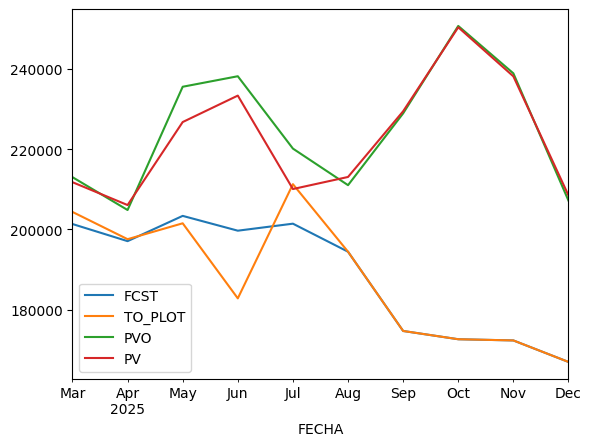

In [26]:
df[(df.MAX_MODEL == True) & (df.FECHA > "2025-02-03")].groupby("FECHA").agg({"FCST":"sum", "TO_PLOT":"sum", "PVO":"sum", "PV":"sum"}).plot()

In [27]:
condiciones = [df["MAX_Modelo"] == col  for col in cols2mape]

valores = [df[col]  for col in cols2mape]

# Valores a imputar según condiciones

df['FCST'] = np.select(condiciones, valores, default=None)

df["TO_PLOT"] = np.where(df.Segmento == 'Validacion', df["FACT"], df["FCST"])

In [7]:
import pandas as pd
import numpy as np

In [8]:
df_2 = pd.read_excel(r"C:\Users\adojeda\Downloads\MejorPronostico2025-07-02.xlsx")

COLS2MAPE = df_2.columns[df_2.columns.str.contains("AVG_MAPE_")]

COLS2MAPE = [i.split("_")[-1] for i in COLS2MAPE]

condiciones = [df_2["MAX_Modelo"] == col  for col in COLS2MAPE]

valores = [df_2[col]  for col in COLS2MAPE]

# Valores a imputar según condiciones

df_2['FCST'] = np.select(condiciones, valores, default=None)

df_2["TO_PLOT"] = np.where(df_2.Segmento == 'Validacion',df_2["FACT"], df_2["FCST"])

In [10]:
df_2

,FECHA,GRUPO,DIRECCION,SUBDIRECCION,GE1,GE2,GE3,BR,FACT,GBR,...,AVG_MAPE_RFR,AVG_MAPE_SVR,AVG_MAPE_GBR,AVG_MAPE_Ridge,AVG_MAPE_KNR,Min_MAPE,MAX_Modelo,MAX_Valores,FCST,TO_PLOT
0,2024-10-01,ACEROS,ACEROS MEXICO,MAYORISTAS ACEROS,PERFILES,REDONDOS Y CUADRADOS,REDONDOS COMERCIALES,29.845782,0.0,20.797603,...,0.619920,0.587575,0.569462,0.586150,0.642026,0.545111,LGBM,38.610728,38.610728,0.0
1,2024-10-01,DEACERO SOLUTIONS,INGETEK,COMERCIAL MEXICO INFRAESTRUCTURA,MALLAS Y ALAMBRES,NEGROS ANTAAC,ALAMBRE RECOCIDO,23.515600,0.0,65.397500,...,0.940819,0.957413,0.916606,0.846482,0.923170,0.846482,Ridge,23.755200,23.7552,0.0
2,2024-10-01,USA,EUA - CANADA,INDUSTRIAL WIRE,MALLAS Y ALAMBRES,FASTENERS MCSW,50#,39.743650,0.0,37.114699,...,0.462497,0.489398,0.444436,0.427636,0.531230,0.422121,BR,39.743650,39.74365,0.0
3,2024-10-01,USA,EUA - CANADA,INDUSTRIAL WIRE,MALLAS Y ALAMBRES,INDUSTRIAL NEGROS,TENSILAC,192.442300,0.0,153.652200,...,0.631964,0.717091,0.489085,0.501809,0.723257,0.489085,GBR,153.652200,153.6522,0.0
4,2024-10-01,USA,EUA - CANADA,INDUSTRIAL WIRE,MALLAS Y ALAMBRES,INDUSTRIAL NEGROS,UNIDAD DE COLCHON,50.816053,0.0,47.744872,...,0.659321,0.638891,0.616293,0.551924,0.783720,0.540046,BR,50.816053,50.816053,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27715,2028-12-01,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA,VARILLA 1/2,5550.128800,0.0,3401.165000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,WOC,3925.250238,3925.250238,3925.250238
27716,2028-12-01,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA,VARILLA 3/4,352.435144,0.0,130.617501,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,WOC,214.651963,214.651963,214.651963
27717,2028-12-01,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA,VARILLA 3/8,3852.389800,0.0,5165.333900,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,WOC,4390.944689,4390.944689,4390.944689
27718,2028-12-01,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA,VARILLA 5/8,2768.026100,0.0,3378.578900,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,WOC,2400.350055,2400.350055,2400.350055


In [9]:
df_2[df_2.FECHA.dt.year == 2025].groupby(["FECHA","Segmento"]).agg({"FCST":"sum", "TO_PLOT":"sum"})

,,FCST,TO_PLOT
FECHA,Segmento,,
2025-01-01,Validacion,397797.371353,337579.820904
2025-02-01,Validacion,391052.664619,320410.55912
2025-03-01,Validacion,367188.253691,297143.962961
2025-04-01,Pronostico,360011.378652,360011.378652
2025-05-01,Pronostico,363936.243624,363936.243624
2025-06-01,Pronostico,211168.434913,211168.434913
2025-07-01,Pronostico,210346.477006,210346.477006
2025-08-01,Pronostico,207044.570856,207044.570856
2025-09-01,Pronostico,215365.616653,215365.616653


In [30]:
df.groupby("FECHA").agg({"FCST":"sum", "TO_PLOT":"sum", "PVO":"sum", "PV":"sum"})

,FCST,TO_PLOT,PVO,PV
FECHA,,,,
2025-02-01,300880.081302,342845.162388,298645.26291,288215.995480
2025-03-01,293400.390139,314307.60376,283287.80707,280563.115520
2025-04-01,275452.6196,287746.868562,267645.11609,269507.289160
2025-05-01,293689.339837,300438.61289,314273.67653,315664.116740
2025-06-01,291055.658982,279451.11279,316633.67032,310904.255010
2025-07-01,292947.339631,317042.265877,287276.35139,278331.420300
2025-08-01,283841.837921,283841.837921,279007.84376,276578.383510
2025-09-01,213380.708676,213380.708676,321046.08538,325518.982720
2025-10-01,203039.460655,203039.460655,327597.20421,330626.805088
